## Loading required packages

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import requests#News scraper
import xml.etree.ElementTree as ET#API for parsing and creating XML data
from newspaper import Article#News extracting
# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
#Sentiment analysis
from textblob import TextBlob
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

## Loading risk events data

We manually searched risk events of the six vendors on Google and collected the dates that the events happened. For a certain risk event, we chose the earliest issue date as the base date. Here we load risk event data that we manully collected previosly.

In [3]:
#Read csv data
company = pd.read_csv('data.csv').drop_duplicates().fillna(0)

In [4]:
company.head()

,name,date,source,sentiment
0,ServiceNow,2019/6/27,https://www.crn.com/news/security/wipro-attack...,Negative
1,ServiceNow,2019/7/24,https://siliconangle.com/2019/07/24/servicenow...,Negative
2,ServiceNow,2019/10/22,https://www.sandiegouniontribune.com/business/...,Negative
3,ServiceNow,2020/9/23,https://www.theregister.com/2020/09/23/service...,Neutral
4,RSA,2011/3/17,https://www.wired.com/2011/08/how-rsa-got-hacked,Negative


In [5]:
#Modify the date format
company['date'] = company['date'].apply(lambda x: datetime.datetime.strptime(str(x), "%Y/%m/%d").date().strftime("%Y-%m-%d"))

In [6]:
company.head()

,name,date,source,sentiment
0,ServiceNow,2019-06-27,https://www.crn.com/news/security/wipro-attack...,Negative
1,ServiceNow,2019-07-24,https://siliconangle.com/2019/07/24/servicenow...,Negative
2,ServiceNow,2019-10-22,https://www.sandiegouniontribune.com/business/...,Negative
3,ServiceNow,2020-09-23,https://www.theregister.com/2020/09/23/service...,Neutral
4,RSA,2011-03-17,https://www.wired.com/2011/08/how-rsa-got-hacked,Negative


In [7]:
#Create a list of company names
names = list(company.name.unique()) #['ServiceNow','RSA','IBM','Equifax','FitBit','Cigna Corp.']
names

['ServiceNow', 'RSA', 'IBM', 'Equifax', 'FitBit', 'Cigna Corp.']

In [8]:
company_dict = {} #Create a dictionary to save company name and the date of risk events
temp = pd.DataFrame()
for i in names:
    temp = company[company['name'] == i] #Slices of dataframe
    company_dict[i] = list(temp['date'])

In [9]:
company_dict

{'ServiceNow': ['2019-06-27', '2019-07-24', '2019-10-22', '2020-09-23'],
 'RSA': ['2011-03-17',
  '2011-03-17',
  '2020-11-27',
  '2011-03-17',
  '2011-03-24',
  '2020-02-18'],
 'IBM': ['2020-05-22',
  '2020-01-31',
  '2020-01-31',
  '2020-10-20',
  '2020-10-08',
  '2015-02-04',
  '2020-04-21',
  '2020-06-01'],
 'Equifax': ['2017-09-07'],
 'FitBit': ['2017-01-30'],
 'Cigna Corp.': ['2016-02-21', '2016-02-21']}

In [10]:
#Build a synonyms pool for company names to filter relative news
pool = {'ServiceNow':['ServiceNow','Servicenow','servicenow'],
       'RSA':['RSA','rsa'],
       'IBM':['IBM','ibm'],
       'Equifax':['Equifax','equifax'],
       'FitBit':['FitBit','Fitbit','fitbit'],
        'Cigna Corp.':[ 'Cigna Corp.','Cigna Corp', 'Cigna', 'cigna']}

## News Scraping

We built a general Google News scraper to request news data that we used in the analysis by inputting the keywords, start date, and end date. In this project, the keywords are the six vendors’ names, the start dates are 30 days and 7 days before the risk event happened respectively, and the end date is one day ahead of the date that the risk event happened. Then a news extractor was employed to get the contents of each news that the scraper had found on Google. The contents of the news were unstructured text data, so we performed Natural Language Processing techniques to pre-processed and analyzed the data.

### Google News scraper

Building a general Google News scraper to collect news from Google by inputting company name, the start date of the news, and the end date of the news.

In [2]:
def scrap_news(search_term, start_date, end_date):
    time =  'after%3A'+ start_date + '+before%3A' + end_date #Time format in url
    url = f'https://news.google.com/rss/search?q={search_term}+'+time+'&hl=en-US&gl=US&ceid=US%3Aen'#Creating customized url to search news
    response = requests.get(url)#request news from Google News
    root= ET.fromstring(response.text)#Creating text from news files
    #get title, link, description, date, source of the news
    title = [i.text for i in root.findall('.//channel/item/title') ]
    link = [i.text for i in root.findall('.//channel/item/link') ]
    description = [i.text for i in root.findall('.//channel/item/description') ]
    pubDate = [i.text for i in root.findall('.//channel/item/pubDate') ]
    source = [i.text for i in root.findall('.//channel/item/source') ]
    # set the data frame
    df = pd.DataFrame({'title':title, 'link':link, 'date':pubDate,'source':source })
    # adjust the date
    df.date = pd.to_datetime(df.date, unit='ns')
    return df

Requesting news from Google News by inputting vendors' names, the start date, and the end date.

In [11]:
data = pd.DataFrame()
for k,v in company_dict.items():
    search_term = str(k)
    for i in v:
        data_temp = pd.DataFrame()#Create a dataframe to temporarily save search result
        data_temp_filtered = pd.DataFrame()#Create a dataframe to temporarily save filtered search result
        risk_date = i
        #The end date is 1 days before the date that risk event happens
        end_date = datetime.datetime.strptime(risk_date, '%Y-%m-%d').date() - datetime.timedelta(1)
        #The start date is 31 days before the date that risk event happens
        start_date = datetime.datetime.strptime(risk_date, '%Y-%m-%d').date() - datetime.timedelta(31)
        try:
            data_temp = scrap_news(search_term, str(start_date), str(end_date))
        except:
            print('Error: '+ k +'\t'+ risk_date)
        #Filtering news data by its title
        for j in range(len(data_temp)):
            temp_count = 0#An indicator, if >0 then the title of the news contains search term; 0 otherwise
            for s in pool[search_term]:
                temp_count += len(re.findall(s, data_temp.iloc[j].title))
            if temp_count > 0: #Filtering the news with the search term in title
                data_temp_filtered = data_temp_filtered.append(data_temp.iloc[j])
        if data_temp_filtered.empty != True:
            data_temp_filtered.insert(0, 'company', search_term)
            data_temp_filtered.insert(1, 'base', datetime.datetime.strftime(end_date,'%Y-%m-%d'))
            data_temp_filtered.insert(2, 'id', range(1,int(len(data_temp_filtered)+1)))
            data = data.append(data_temp_filtered)
            
data = data.reset_index(drop = True)
print("Finished.")

Execution time 21.28184700012207


In [13]:
len(data)

1070

### News extractor

Building a news extractor by inputting the news links got from the news scraper previously.

In [16]:
text = []
summary = []
keywords = []
keywords_temp = ""
for url in data["link"].tolist():
    current_article = Article(url, language="en")#specify the url
    #download the article 
    try:
        current_article.download()
        current_article.parse()#parse the article 
        current_article.nlp()#perform NLP
        text.append(current_article.text.replace('\n',' ').replace('\t',' '))
        summary.append(current_article.summary)
        keywords_temp = ",".join(words for words in current_article.keywords)
        keywords.append(keywords_temp)
    except:
        print('Error ', current_article.url)
        text.append("None")
        summary.append("None")
        keywords.append("None")
        continue
data['text'] = text
data['summary'] = summary
data['keywords'] = keywords
print("Finished.")

C:\Users\demo9\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


***FAILED TO DOWNLOAD*** https://www.bizjournals.com/sanjose/news/2019/06/07/servicenow-santa-clara-hq-expansion-lease-sobrato.html
***FAILED TO DOWNLOAD*** https://www.barrons.com/articles/slack-servicenow-and-other-software-stocks-fall-on-bearish-morgan-stanley-report-51571237855
***FAILED TO DOWNLOAD*** https://seekingalpha.com/article/4294850-servicenow-buynow-hold-for-later
***FAILED TO DOWNLOAD*** https://www.forbes.com/sites/greatspeculations/2020/08/24/up-76-servicenow-stock-is-too-high/
***FAILED TO DOWNLOAD*** https://www.itp.net/news/93863-servicenow-unveils-now-platform-to-enhance-business-agility-and-resilience
***FAILED TO DOWNLOAD*** https://seekingalpha.com/article/4374313-servicenow-growth-rates-dont-support-valuation
***FAILED TO DOWNLOAD*** https://siliconangle.com/2020/09/03/cisco-servicenow-collaborate-workplace-contact-tracing/
***FAILED TO DOWNLOAD*** https://seekingalpha.com/article/4374266-servicenow-inc-now-management-presents-jefferies-virtual-software-confer

C:\Users\demo9\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


***FAILED TO DOWNLOAD*** https://www.fnlondon.com/articles/meet-the-queen-of-ma-at-goldman-sachs-who-advised-on-the-7-2bn-rsa-takeover-20201118
***FAILED TO DOWNLOAD*** https://citywire.co.uk/investment-trust-insider/news/friday-papers-foreign-bidders-in-7bn-swoop-on-rsa/a1422179
***FAILED TO DOWNLOAD*** https://citywire.co.uk/funds-insider/news/the-uk-funds-reaping-a-reward-from-rsas-7bn-bid-and-rally/a1422465
***FAILED TO DOWNLOAD*** https://nairametrics.com/2020/11/15/how-to-transfer-your-retirement-savings-account-rsa/
***FAILED TO DOWNLOAD*** https://nairametrics.com/2020/11/19/rsa-transfer-what-to-look-for-in-a-fund-manager/
***FAILED TO DOWNLOAD*** https://nairametrics.com/2020/11/09/pencom-fix-nov-16-for-launch-of-rsa-transfer-system/
***FAILED TO DOWNLOAD*** https://www.bizjournals.com/wichita/blog/2011/02/snyder-joins-rowley-ablah-firm.html
***FAILED TO DOWNLOAD*** https://siliconangle.com/2020/02/16/coronavirus-fears-see-facebook-cancel-conference-ibm-pull-rsa/
***FAILED TO 

***FAILED TO DOWNLOAD*** https://www.forbes.com/sites/rahulrazdan/2020/04/04/linux-beat-ibm-will-open-source-software-beat-waymo-and-tesla/
***FAILED TO DOWNLOAD*** https://www.forbes.com/sites/darrynpollock/2020/04/15/nestl-expands-use-of-ibm-food-trust-blockchain-to-its-zogas-coffee-brand/
***FAILED TO DOWNLOAD*** https://www.forbes.com/sites/robertanzalone/2020/04/08/ibms-growing-blockchain-networks-could-strengthen-our-supply-chain-in-response-to-covid-19/
***FAILED TO DOWNLOAD*** https://www.sdxcentral.com/articles/news/ibm-cloud-amd-debut-epyc-bare-metal/2020/04/
***FAILED TO DOWNLOAD*** https://www.forbes.com/sites/greatspeculations/2020/03/30/is-30-upside-for-ibms-stock-possible-post-covid-19-crisis/
***FAILED TO DOWNLOAD*** https://www.bizjournals.com/triangle/news/2020/04/06/tbj-plus-ibms-new-ceo-details-strategy-amid.html
***FAILED TO DOWNLOAD*** https://www.forbes.com/sites/moorinsights/2020/04/14/ibm-bolsters-z-portfolio-with-new-data-privacy-capabilities/
***FAILED TO DOW

In [17]:
data.head()

,company,base,id,date,link,source,title,text,summary,keywords
0,ServiceNow,2019-06-26,1,2019-06-13 07:00:00+00:00,https://www.crn.com/news/channel-programs/serv...,CRN,ServiceNow Picks Partner's Disaster Recovery A...,A ServiceNow partner recently had one of the b...,"Fairchild designed its app, MaestroRS, to help...","recovery,platform,expertise,support,partners,m..."
1,ServiceNow,2019-06-26,2,2019-06-06 07:00:00+00:00,https://www.mercurynews.com/2019/06/06/service...,The Mercury News,ServiceNow deal creates huge Santa Clara campu...,SANTA CLARA — ServiceNow has struck a deal tha...,SANTA CLARA — ServiceNow has struck a deal tha...,"santa,square,huge,deal,clara,firm,lane,sobrato..."
2,ServiceNow,2019-06-26,3,2019-06-15 07:00:00+00:00,https://www.channele2e.com/investors/exits/ser...,ChannelE2E,ServiceNow Partner Acorio Acquires BusinessFor...,"Acorio, a pure-play ServiceNow consultancy fro...","Acorio, a pure-play ServiceNow consultancy fro...","partners,partner,company,management,acorio,bus..."
3,ServiceNow,2019-06-26,4,2019-05-29 07:00:00+00:00,https://cloudwars.co/servicenow/servicenow-bre...,Cloud Wars,ServiceNow's Breakthrough Strategy: Create 'Sy...,With a market cap of $50 billion and annual re...,As part of our Cloud Wars Top 10 ‘Executive In...,"servicenows,think,hospitals,action,great,way,c..."
4,ServiceNow,2019-06-26,5,2019-06-20 07:00:00+00:00,https://www.businesswire.com/news/home/2019062...,Business Wire,Slack Integration from ServiceNow Partner Cros...,"ARLINGTON, Va.--(BUSINESS WIRE)--Crossfuze, a ...",The Slack Approvals Integration for ServiceNow...,"process,integration,crossfuzes,partner,slack,i..."
...,...,...,...,...,...,...,...,...,...,...
1065,Cigna Corp.,2016-02-20,2,2016-01-22 08:00:00+00:00,https://www.reuters.com/article/us-cigna-medic...,Reuters,U.S. government suspends enrollment in Cigna M...,(Reuters) - The U.S. government has suspended ...,(Reuters) - The U.S. government has suspended ...,"drug,medicare,suspends,advantage,suspension,ce..."
1066,Cigna Corp.,2016-02-20,3,2016-02-17 08:00:00+00:00,https://www.courant.com/business/hc-cigna-pens...,Hartford Courant,Long-Running Lawsuit By Cigna Employees Nears ...,If workers left before the cash balance grew l...,If workers left before the cash balance grew l...,"employees,finish,left,longrunning,women,cigna,..."
1067,Cigna Corp.,2016-02-20,1,2016-02-10 08:00:00+00:00,https://www.businessinsurance.com/article/2016...,Business Insurance,"Cigna, Aetna enter outcomes-based contract wit...",Amid growing pressure on pharmaceutical compan...,Amid growing pressure on pharmaceutical compan...,"drug,insurers,novartis,employers,mr,enter,cign..."
1068,Cigna Corp.,2016-02-20,2,2016-01-22 08:00:00+00:00,https://www.reuters.com/article/us-cigna-medic...,Reuters,U.S. government suspends enrollment in Cigna M...,(Reuters) - The U.S. government has suspended ...,(Reuters) - The U.S. government has suspended ...,"drug,medicare,suspends,advantage,suspension,ce..."


In [18]:
data = data[data['text'] != 'None'] #Select non-empty news

In [19]:
len(data)

970

## Text Cleansing

After getting the news text, we removed stop words and noisy characters from the text because they didn’t add much meaning to a sentence. We performed part-of-speech tagging, tokenization, and lemmatization, which are NLP techniques, to transform the words in the news text into the original form.

### Stop Words

In [20]:
stop_words = set(stopwords.words('english'))
stop_append = ['.', ',', '`', '"', "'", '!', ';',  '%']
stop_words = list(stop_words.union(stop_append))

### Part-of-Speech (PoS) Tagging

We employed nltk package to perform lemmatization so that the words could be transformed into the original forms. But before doing that, we have to tag the word to have a more precise result by means of several helper functions.

In [21]:
# list of word types 
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
# build several helper functions to determine the PoS
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']
def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']
def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def tagging(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN

### Lemmatization and Tokenization

Building a lemmatizer and a tokenizer in a function named clean.

In [22]:
def clean(doc):
    # pattern for numbers in the text
    pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
    # convert to lowercase
    doc = doc.lower()
    # tokenize document
    doc_tok = None
    doc_tok = word_tokenize(doc)
    # filter out patterns from words
    doc_tok = [x for x in doc_tok if x not in stop_words]
    doc_tok = [pattern.sub('', x) for x in doc_tok]
    # remove words less than three letters
    doc_tok = [x for x in doc_tok if len(x) > 2]
    # position tagging
    doc_tagged = nltk.pos_tag(doc_tok)
    # selecting nouns, verbs and adjectives
    doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
    # preparing lemmatization
    doc = [(t[0], tagging(t[1])) for t in doc_tagged]
    # lemmatization
    doc = " ".join([WordNetLemmatizer().lemmatize(word = t[0], pos = t[1]) for t in doc])
    return doc

In [23]:
data["text_clean"] = data.text.map(clean)

C:\Users\demo9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
data["text_clean"].head()

0    servicenow partner business continuity disaste...
1    santa clara servicenow struck deal enables com...
2    acorio pureplay servicenow consultancy boston ...
3    market cap annual revenue servicenow blow past...
4    arlington business wire crossfuze lead service...
Name: text_clean, dtype: object

## Sentiment Analysis

We built a sentiment analysis model. We used the TextBlob package in python to come up with the sentiment score for each piece of news based on the cleaned data about the corresponding vendors. Then we calculated the negative news rate, which is the number of negative news divided by the total number of news, for each vendor in periods of 30 days and 7 days respectively by Excel.

In [26]:
def senti(x):
    return TextBlob(x).sentiment.polarity
data['sentiment_score'] = data["text_clean"].apply(senti)

C:\Users\demo9\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
data['sentiment_score']

0       0.306277
1       0.085511
2       0.077706
3       0.249767
4       0.150766
          ...   
1065   -0.021260
1066    0.069196
1067   -0.020968
1068   -0.021260
1069    0.069196
Name: sentiment_score, Length: 970, dtype: float64

In [48]:
output30 = data[["company","date", "sentiment_score"]]#data to be writen to a csv file

In [49]:
output30.head()

,company,date,sentiment_score
0,ServiceNow,2019-06-13 07:00:00+00:00,0.306277
1,ServiceNow,2019-06-06 07:00:00+00:00,0.085511
2,ServiceNow,2019-06-15 07:00:00+00:00,0.077706
3,ServiceNow,2019-05-29 07:00:00+00:00,0.249767
4,ServiceNow,2019-06-20 07:00:00+00:00,0.150766
...,...,...,...
1065,Cigna Corp.,2016-01-22 08:00:00+00:00,-0.021260
1066,Cigna Corp.,2016-02-17 08:00:00+00:00,0.069196
1067,Cigna Corp.,2016-02-10 08:00:00+00:00,-0.020968
1068,Cigna Corp.,2016-01-22 08:00:00+00:00,-0.021260


In [51]:
output30.to_csv("30days.csv", header=True, index= False)#Save the data into a csv file

## Data Visualization

We compared the negative news of different vendors in the box plot, table, and word cloud to draw the conclusion.This part shows the word cloud generation process.

In [29]:
data_sub = data[data['sentiment_score']<0]#create a subset of news with negative sentiment scores
names = list(data_sub.company.unique())#get the vendor names in the subset to check if any one of the vendor does not have any negative news
names

['ServiceNow', 'RSA', 'IBM', 'Equifax', 'FitBit', 'Cigna Corp.']

In [34]:
data_sub.head()

,company,base,id,date,link,source,title,text,summary,keywords,text_clean,sentiment_score
18,ServiceNow,2019-06-26,19,2019-06-07 07:00:00+00:00,https://marketrealist.com/2019/06/servicenow-s...,Market Realist,ServiceNow Stock Has Gained More than 50.0% in...,ServiceNow’s (NOW) stock performance has easil...,ServiceNow’s (NOW) stock performance has easil...,"500,servicenows,rise,sales,stock,risen,does,20...",servicenow stock performance outperform broad ...,-0.046875
20,ServiceNow,2019-06-26,21,2019-06-25 07:00:00+00:00,https://marketrealist.com/2019/06/a-look-at-se...,Market Realist,A Look at ServiceNow's Earnings and Revenue Gr...,High-growth technology company ServiceNow (NOW...,High-growth technology company ServiceNow (NOW...,"servicenows,rise,revenue,earnings,sales,expect...",highgrowth technology company servicenow see s...,-0.042500
41,ServiceNow,2019-07-23,18,2019-07-10 07:00:00+00:00,https://www.automation.com/en-us/products/prod...,Automation.com,Opsview announces bi-directional native Servic...,Opsview announces bi-directional native Servic...,Opsview announces bi-directional native Servic...,"native,integration,notifications,bidirectional...",opsview announces directional native serviceno...,-0.040000
46,ServiceNow,2019-07-23,23,2019-06-25 07:00:00+00:00,https://marketrealist.com/2019/06/a-look-at-se...,Market Realist,A Look at ServiceNow's Earnings and Revenue Gr...,High-growth technology company ServiceNow (NOW...,High-growth technology company ServiceNow (NOW...,"servicenows,rise,revenue,earnings,sales,expect...",highgrowth technology company servicenow see s...,-0.042500
51,ServiceNow,2019-10-21,3,2019-10-16 07:00:00+00:00,https://www.itjungle.com/2019/10/16/syncsort-e...,IT Jungle,Syncsort Expands IBM i Integration with Servic...,Syncsort Expands IBM i Integration with Servic...,Syncsort Expands IBM i Integration with Servic...,"product,syncsort,service,offering,event,integr...",syncsort expand ibm integration servicenow ale...,-0.070700
...,...,...,...,...,...,...,...,...,...,...,...,...
1062,FitBit,2017-01-29,44,2017-01-25 08:00:00+00:00,https://metro.co.uk/2017/01/25/new-fitbit-styl...,Metro,Chinese Fitbit-style bracelet ‘doesn’t work on...,Shutterstock A new Fitbit-style bracelet from...,ShutterstockA new Fitbit-style bracelet from a...,"fitbitstyle,mi,issue,work,measure,doesnt,heart...",shutterstock new fitbitstyle bracelet chinese ...,-0.133131
1064,Cigna Corp.,2016-02-20,1,2016-02-10 08:00:00+00:00,https://www.businessinsurance.com/article/2016...,Business Insurance,"Cigna, Aetna enter outcomes-based contract wit...",Amid growing pressure on pharmaceutical compan...,Amid growing pressure on pharmaceutical compan...,"drug,insurers,novartis,employers,mr,enter,cign...",grow pressure pharmaceutical company prove dru...,-0.020968
1065,Cigna Corp.,2016-02-20,2,2016-01-22 08:00:00+00:00,https://www.reuters.com/article/us-cigna-medic...,Reuters,U.S. government suspends enrollment in Cigna M...,(Reuters) - The U.S. government has suspended ...,(Reuters) - The U.S. government has suspended ...,"drug,medicare,suspends,advantage,suspension,ce...",reuters government suspend new enrollment cign...,-0.021260
1067,Cigna Corp.,2016-02-20,1,2016-02-10 08:00:00+00:00,https://www.businessinsurance.com/article/2016...,Business Insurance,"Cigna, Aetna enter outcomes-based contract wit...",Amid growing pressure on pharmaceutical compan...,Amid growing pressure on pharmaceutical compan...,"drug,insurers,novartis,employers,mr,enter,cign...",grow pressure pharmaceutical company prove dru...,-0.020968


In [31]:
def Show_Word_Cloud(corpus_str,company_name):
    wordcloud = WordCloud(background_color='white',
                          width=500, height=300,
                          stopwords=stop_words,
                          max_words=30,
                          max_font_size=60, 
                          random_state=42
                         ).generate(corpus_str)
    print(wordcloud)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    name = company_name + ".png"#save the word cloud as a .png file
    fig.savefig(name, dpi=900)

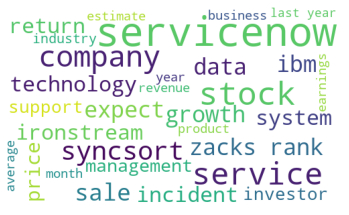

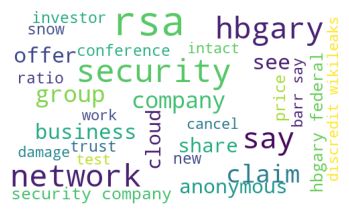

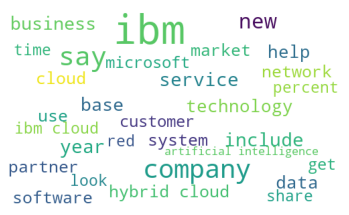

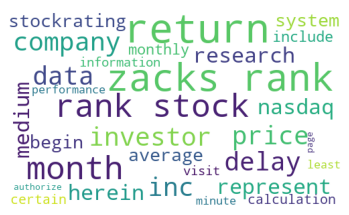

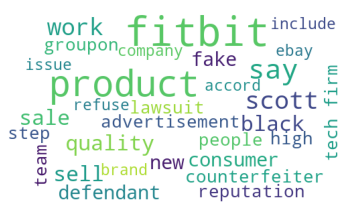

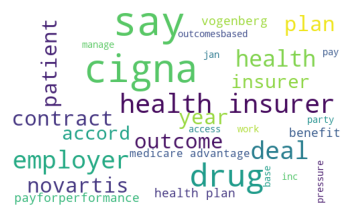

In [32]:
#Create word clouds based on cleaned data with negative sentiment scores by company names
for i in names:
    temp_list = []
    temp_test = ''
    temp_list = list(data_sub[data_sub['company'] == i]['text_clean'])
    for j in temp_list:
        temp_test += j
    Show_Word_Cloud(temp_test,i)

By creating word clouds for each vendor based on negative news in the past 30 days, we visualized the topics that the news discussed so that people will realize and understand the main risk of a certain company before a risk event happens. 
For example, from the word cloud of FitBit, we notice that there are some keywords related to risk such as “fake”, “lawsuit”, “defendant”. So we need to pay attention to the potential legal risk of FitBit. The word cloud of RSA shows that there are keywords such as “network” and “security”. So we should care more about the cybersecurity of RSA.